In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/mergedData.csv')

In [3]:
#View Dataset
df.head()

,wid,hmid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,age,country,gender,marital,parenthood
0,1,107914,3m,I got to spend the day with my niece that i ha...,I got to spend the day with my niece that i ha...,True,1,NaN,affection,37,USA,m,married,y
1,1,27854,24h,My wife and i are celebrating our ten year ann...,My wife and i are celebrating our ten year ann...,True,1,NaN,affection,37,USA,m,married,y
2,1,28991,24h,My wife cooked me a surprise dinner to take to...,My wife cooked me a surprise dinner to take to...,True,1,NaN,affection,37,USA,m,married,y
3,1,47392,24h,My mom cooked dinner for us all and it was del...,My mom cooked dinner for us all and it was del...,True,1,NaN,affection,37,USA,m,married,y
4,1,41494,24h,On my way to work i got hit on by a complete s...,On my way to work i got hit on by a complete s...,True,1,NaN,enjoy_the_moment,37,USA,m,married,y


In [4]:
d = df[['cleaned_hm','predicted_category']]

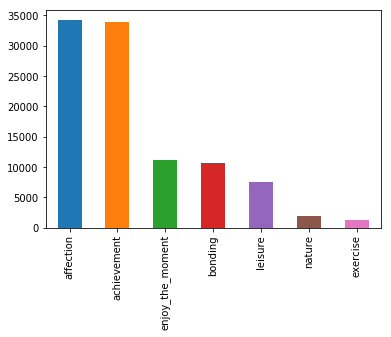

In [5]:
# Looks at breakfown of happiness category
%matplotlib inline
d.predicted_category.value_counts().plot(kind='bar')

In [6]:
# Create variables to be able to predict
X = d.cleaned_hm
y = d.predicted_category

In [7]:
print(X.shape)
print(y.shape)

(100535,)
(100535,)


In [8]:
# Import packages
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Initialize model and arrays
model = LinearSVC()
scores = []
i_val = []

# train/test/split the dataset 
X_train, X_test, y_train, y_test = train_test_split(d['cleaned_hm'], d['predicted_category'], random_state = 0)

In [9]:
# For loop to calculate accuracy per amount of max_feautres
for i in range(0,25400,100):
    if i == 0:
        i=1
    i_val.append(i)
    count_vect = CountVectorizer(max_features = i)
    X_train_counts = count_vect.fit_transform(X_train)
    X_test_counts = count_vect.transform(X_test)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    scores.append(accuracy_score(y_test, y_pred))

KeyboardInterrupt: 

In [ ]:
# plots accuracy as number of features increases by 100
plt.plot(i_val, scores)
plt.title('Accuracy vs Number of Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Features')
plt.show()

In [ ]:
# creates accuracy dataframe
acc_df = pd.DataFrame(
    {'Accuracy': scores,
     'Features': i_val
    })

In [ ]:
ch = acc_df[(acc_df['Features']>5000) & (acc_df['Features']<8000)]

In [ ]:
%matplotlib inline
#Looks closely as range of features between 5000 and 8000 words
ch.plot('Features',"Accuracy")

In [ ]:
# Reruns similar code to before just with a hardcoded 6700 max features
X_train, X_test, y_train, y_test = train_test_split(d['cleaned_hm'], d['predicted_category'], random_state = 0)
count_vect = CountVectorizer(max_features = 6700)
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
accuracy_score(y_test, y_pred)

In [ ]:
# compares accuracy to SGD model
from sklearn import linear_model
SGD = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
SGD.fit(X_train_tfidf, y_train)
y_pred_SGD = SGD.predict(X_test_tfidf)
accuracy_score(y_test, y_pred_SGD)

In [ ]:
#Cross validation for Linear SVC and SGD
from sklearn.model_selection import cross_val_score

X = d['cleaned_hm']
X = count_vect.fit_transform(X)
X = tfidf_transformer.fit_transform(X)
y = d['predicted_category']
print(cross_val_score(model, X, y, cv=5))
print(cross_val_score(SGD, X, y, cv=5))

In [ ]:
# Creates confusion matrix for predicted category
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=d.predicted_category.unique(), yticklabels=d.predicted_category.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Shows classification report
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=d.predicted_category.unique()))

In [ ]:
df = d.copy()

In [ ]:
# created new dataframe to see top words.
df['category_id'] = df['predicted_category'].factorize()[0]
category_id_df = df[['predicted_category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'predicted_category']].values)
df.head()

In [ ]:
# min_df  is the minimum numbers of documents a word must be present in to be kept.
# varying this changes word

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

In [ ]:
tfidf.fit_transform(df.cleaned_hm).toarray()

In [ ]:
N = 2
for predicted_category, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(predicted_category))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))